In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Reshape, Dropout, LayerNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import concatenate
sc = MinMaxScaler(feature_range = (0,1))

import pandas as pd

In [15]:
df1 = pd.read_csv('./Poisson8GData/U08_ONU16_15S_Gi-1_48133_0428.csv', usecols=[0], engine='python')
df1.head()

,Gi - 1
0,15794
1,8693
2,17019
3,32568
4,15332


In [16]:
df2 = pd.read_csv('./Poisson8GData/U08_ONU16_15S_Ri_43758_0428.csv', usecols=[0], engine='python')
df2.head()

,Ri
0,8693
1,15472
2,29608
3,13939
4,11147


In [17]:
df3 = pd.read_csv('./Poisson8GData/U08_ONUAi_ONU16.csv', usecols=[0], engine='python')
df3.head()

,Ai
0,15472
1,31155
2,16808
3,12416
4,8552


In [18]:
df1 = df1.values
df1 = df1.astype('float32')

df2 = df2.values
df2 = df2.astype('float32')

df3 = df3.values
df3 = df3.astype('float32')

In [19]:
print(np.max(df1))
print(np.max(df2))
print(np.max(df3))
#df2 = []

#for i in range(len(df)):
#    if(df[i] > 195000.0):
#        df[i] = 195000.0
#    df2.append(df[i])

48133.0
43758.0
45440.0


In [20]:
#df = df2
df1 = df1[:46651]
df2 = df2[:46651]
print(len(df1))
print(len(df2))
print(len(df3))

46651
46651
46651


In [21]:
# normalize the dataset
#scaler = MinMaxScaler(feature_range=(0, 1))
#datasetG = scaler.fit_transform(df1)
#datasetA = scaler.fit_transform(df2)
datasetG = df1
datasetR = df2
datasetA = df3

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [23]:
# split into train and test sets
train_sizeG = int(len(datasetG) * 0.7) 
test_sizeG = len(datasetG) - train_sizeG
trainG, testG = datasetG[0:train_sizeG], datasetG[train_sizeG:len(datasetG)]

trainG = scaler.fit_transform(trainG)
testG = scaler.fit_transform(testG)
print(len(trainG), len(testG))

32655 13996


In [24]:
# split into train and test sets
train_sizeR = int(len(datasetR) * 0.7) 
test_sizeR = len(datasetR) - train_sizeR
trainR, testR = datasetR[0:train_sizeR], datasetR[train_sizeR:len(datasetR)]

#scaler = MinMaxScaler(feature_range=(0, 1))
trainR = scaler.fit_transform(trainR)
testR = scaler.fit_transform(testR)
print(len(trainR), len(testR))

32655 13996


In [25]:
# split into train and test sets
train_sizeA = int(len(datasetA) * 0.7) 
test_sizeA = len(datasetA) - train_sizeA
trainA, testA = datasetA[0:train_sizeA], datasetA[train_sizeA:len(datasetA)]

#scaler = MinMaxScaler(feature_range=(0, 1))
trainA = scaler.fit_transform(trainA)
testA = scaler.fit_transform(testA)
print(len(trainA), len(testA))

32655 13996


In [26]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [27]:
# reshape into X=t and Y=t+1
look_back = 10 #16
trainX_G, trainY_G = create_dataset(trainG, look_back)
testX_G, testY_G = create_dataset(testG, look_back)

trainX_R, trainY_R = create_dataset(trainR, look_back)
testX_R, testY_R = create_dataset(testR, look_back)

trainX_A, trainY_A = create_dataset(trainA, look_back)
testX_A, testY_A = create_dataset(testA, look_back)

In [28]:
# reshape input to be [samples, time steps, features]
trainX_G = np.reshape(trainX_G, (trainX_G.shape[0], look_back, 1))
testX_G = np.reshape(testX_G, (testX_G.shape[0], look_back, 1))

trainX_R = np.reshape(trainX_R, (trainX_R.shape[0], look_back, 1))
testX_R = np.reshape(testX_R, (testX_R.shape[0], look_back, 1))

trainX_A = np.reshape(trainX_A, (trainX_A.shape[0], look_back, 1))
testX_A = np.reshape(testX_A, (testX_A.shape[0], look_back, 1))
#print(trainX.shape[1])
print(trainX_G.shape)
print(trainY_G.shape)
print(testX_G.shape)
print(testY_G.shape)

print(trainX_R.shape)
print(trainY_R.shape)
print(testX_R.shape)
print(testY_R.shape)

print(trainX_A.shape)
print(trainY_A.shape)
print(testX_A.shape)
print(testY_A.shape)

(32644, 10, 1)
(32644, 1)
(13985, 10, 1)
(13985, 1)
(32644, 10, 1)
(32644, 1)
(13985, 10, 1)
(13985, 1)
(32644, 10, 1)
(32644, 1)
(13985, 10, 1)
(13985, 1)


In [29]:
#inputsR = Input(shape=(timesteps,))
inputs_G = Input(shape=(look_back,))
inputs_R = Input(shape=(look_back,))
#inputs = LayerNormalization(axis=1)(inputs)
#inputs_R_test = Reshape((inputs_R.shape[1],1))(inputs_R)
inputs_G_test = Reshape((inputs_G.shape[1], 1))(inputs_G)
inputs_R_test = Reshape((inputs_R.shape[1], 1))(inputs_R)

input_merge = concatenate([inputs_G_test, inputs_R_test], axis = -1)

tgt1 = Reshape((look_back, 2))(input_merge)

#tf.print(tgt1, output_stream=sys.stderr)

In [30]:
#tgt1 = LSTM(units=40, input_shape=(look_back, 2))(tgt1)
#predictions = Dense(1, activation='relu')(tgt1)

tgt1 = LSTM(units=40, return_sequences = True, input_shape=(look_back, 2))(tgt1)
tgt1 = Dropout(0.2)(tgt1)

tgt2 = LSTM(units=40, return_sequences = True)(tgt1)
tgt2 = Dropout(0.2)(tgt2)

tgt3 = LSTM(units=40, return_sequences = True)(tgt2)
tgt3 = Dropout(0.2)(tgt3)

#tgt4 = LSTM(units=40, return_sequences = True)(tgt3)
#tgt4 = Dropout(0.2)(tgt4)

#tgt5 = LSTM(units=40, return_sequences = True)(tgt4)
#tgt5 = Dropout(0.2)(tgt5)

#tgt6 = LSTM(units=20)(tgt5)
#tgt6 = Dropout(0.2)(tgt6)

#tgt7 = LSTM(units=20, return_sequences = True)(tgt6)
#tgt7 = Dropout(0.2)(tgt7)

#tgt8 = LSTM(units=20, return_sequences = True)(tgt7)
#tgt8 = Dropout(0.2)(tgt8)

#tgt9 = LSTM(units=20, return_sequences = True)(tgt8)
#tgt9 = Dropout(0.2)(tgt9)

tgt4 = LSTM(units=40)(tgt3)
tgt4 = Dropout(0.2)(tgt4)

#tgt6 = LSTM(units=40, return_sequences = True)(tgt5)

#tgt7 = LSTM(units=40)(tgt6)


#tgt5 = Flatten()(tgt5)
predictions = Dense(1, activation='relu')(tgt4)
#predictions = Dense(1)(tgt4)


model = Model(inputs=[inputs_G, inputs_R], outputs=predictions)
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae'])

history = model.fit([trainX_G, trainX_R], trainY_A, epochs=100, batch_size=32) #[1,0,0], [0,0,1]

Epoch 1/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0333 - mse: 0.0333 - mae: 0.1527
Epoch 2/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0297 - mse: 0.0297 - mae: 0.1397
Epoch 3/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0289 - mse: 0.0289 - mae: 0.1371
Epoch 4/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0287 - mse: 0.0287 - mae: 0.1358
Epoch 5/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.1352
Epoch 6/100
1021/1021 [==============================] - 7s 7ms/step - loss: 0.0284 - mse: 0.0284 - mae: 0.1345
Epoch 7/100
1021/1021 [==============================] - 7s 7ms/step - loss: 0.0283 - mse: 0.0283 - mae: 0.1341
Epoch 8/100
1021/1021 [==============================] - 7s 7ms/step - loss: 0.0284 - mse: 0.0284 - mae: 0.1344
Epoch 9/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0283 - mse: 0.0283 - mae:

1021/1021 [==============================] - 6s 6ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1326
Epoch 74/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1325
Epoch 75/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1327
Epoch 76/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1327
Epoch 77/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1324
Epoch 78/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1323
Epoch 79/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1323
Epoch 80/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.1324
Epoch 81/100
1021/1021 [==============================] - 6s 6ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1

look back = timesteps = 10, 4 LSTM layers

timesteps :  10


Text(0.5, 1.0, 'mae')

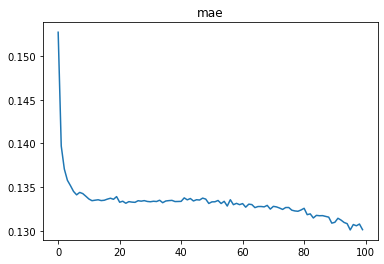

In [31]:
print('timesteps : ', look_back)
plt.plot(history.history['mae'])
plt.title('mae')

timesteps :  10


Text(0.5, 1.0, 'mse')

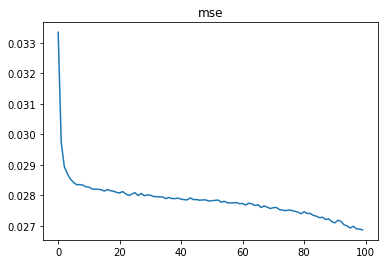

In [32]:
print('timesteps : ', look_back)
plt.plot(history.history['mse'])
plt.title('mse')

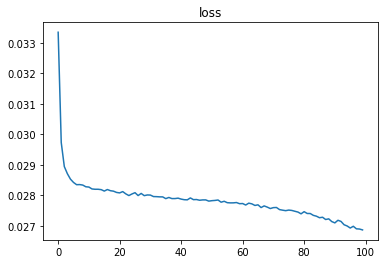

In [33]:
plt.title('loss')
plt.plot(history.history['loss'])

In [34]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 10, 1)        0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 10, 1)        0           input_2[0][0]                    
_______________________________________________________________________________________

In [35]:
from sklearn.metrics import mean_squared_error as mse

trainPredict = model.predict([trainX_G, trainX_R])
testPredict = model.predict([testX_G, testX_R])

In [36]:
# invert predictions
#scaler = MinMaxScaler(feature_range=(0, 1))
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY_A)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY_A)
# calculate root mean squared error
trainScore = math.sqrt(mse(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mse(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
# calculate root mean absolute error
trainScore2 = math.sqrt(mae(trainY, trainPredict))
print('Train Score: %.2f RMAE' % (trainScore2))
testScore2 = math.sqrt(mae(testY, testPredict))
print('Test Score: %.2f RMAE' % (testScore2))

Train Score: 7306.88 RMSE
Test Score: 7502.19 RMSE
Train Score: 76.26 RMAE
Test Score: 76.80 RMAE


In [37]:
#testPredictPlot = np.empty_like(datasetG)
#testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(datasetG)-1] = testPredict
# plot baseline and predictions
#plt.figure(figsize=(15, 10))
#plt.plot(datasetA[1500:])
#plt.plot(datasetG[1451:])
#plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot[1451:])
#plt.show()

In [38]:
'''
testPredictPlot = np.empty_like(datasetA)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(datasetA)-1] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15, 10))
#plt.plot(datasetA[1500:])
plt.plot(datasetA[14000:15000])
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot[14000:15000])
plt.show()
'''

'\ntestPredictPlot = np.empty_like(datasetA)\ntestPredictPlot[:, :] = np.nan\ntestPredictPlot[len(trainPredict)+(look_back*2)+1:len(datasetA)-1] = testPredict\n# plot baseline and predictions\nplt.figure(figsize=(15, 10))\n#plt.plot(datasetA[1500:])\nplt.plot(datasetA[14000:15000])\n#plt.plot(trainPredictPlot)\nplt.plot(testPredictPlot[14000:15000])\nplt.show()\n'

In [39]:
max(testPredict)

array([26867.947], dtype=float32)

In [40]:
#testPredict

In [41]:
#testY_A

In [42]:
#datasetA[:100]

In [43]:
model.save('U08D00_ONU16_Gi-1_48133_Ri_43758_Ai_45440_4layer40cells_lookback10.h5', include_optimizer=False)